In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sqlalchemy import create_engine


In [18]:
engine = create_engine(
    "postgresql+psycopg2://",
    connect_args={
        "host": "localhost",
        "dbname": "hospital_db",
        "user": "postgres",
        "password": "Balu@123",
        "port": 5432
    }
)

# Force actual connection
with engine.connect() as conn:
    print("Database connection verified successfully!")



Database connection verified successfully!


In [19]:
query = "SELECT * FROM admissions;"
df = pd.read_sql(query, engine)

df.head()


,admission_id,patient_id,diagnosis_id,time_in_hospital,n_procedures,n_lab_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,glucose_test,a1c_test,change,diabetes_med,readmitted
0,1,2,328,10,45,0,12,0,1,0,Missing,no,no,no,no,no
1,2,5,328,5,43,4,17,0,0,0,InternalMedicine,no,no,no,yes,no
2,3,3,328,10,54,3,32,0,0,0,Missing,no,no,no,no,no
3,4,2,328,2,31,0,12,0,0,0,Missing,no,no,no,no,yes
4,5,4,328,5,11,3,16,1,0,0,Surgery,no,no,yes,yes,no


In [20]:
query = """
SELECT medical_specialty,
       COUNT(*) AS total_readmissions
FROM admissions
WHERE readmitted = 'yes'
GROUP BY medical_specialty
ORDER BY total_readmissions DESC;
"""

df_specialty = pd.read_sql(query, engine)

df_specialty.head()


,medical_specialty,total_readmissions
0,Missing,6056
1,InternalMedicine,1596
2,Other,1105
3,Family/GeneralPractice,932
4,Emergency/Trauma,931


In [21]:
#Count Total Rows
pd.read_sql("SELECT COUNT(*) FROM admissions;", engine)

,count
0,25000


In [22]:
#Check Missing Values
query = """
SELECT 
    COUNT(*) FILTER (WHERE medical_specialty IS NULL) AS missing_specialty,
    COUNT(*) FILTER (WHERE glucose_test IS NULL) AS missing_glucose,
    COUNT(*) FILTER (WHERE a1c_test IS NULL) AS missing_a1c,
    COUNT(*) FILTER (WHERE change IS NULL) AS missing_change,
    COUNT(*) FILTER (WHERE diabetes_med IS NULL) AS missing_diabetes_med,
    COUNT(*) FILTER (WHERE readmitted IS NULL) AS missing_readmitted
FROM admissions;
"""

pd.read_sql(query, engine)



,missing_specialty,missing_glucose,missing_a1c,missing_change,missing_diabetes_med,missing_readmitted
0,0,0,0,0,0,0


In [23]:
#Standardize Yes/No Columns
from sqlalchemy import text

with engine.connect() as conn:
    conn.execute(text("""
        UPDATE admissions
        SET 
            change = LOWER(TRIM(change)),
            diabetes_med = LOWER(TRIM(diabetes_med)),
            readmitted = LOWER(TRIM(readmitted));
    """))

print("Yes/No columns standardized")


Yes/No columns standardized


In [24]:
#Clean Test Result Columns
with engine.connect() as conn:
    conn.execute(text("""
        UPDATE admissions
        SET 
            glucose_test = LOWER(TRIM(glucose_test)),
            a1c_test = LOWER(TRIM(a1c_test));
    """))

print("Test result columns standardized")


Test result columns standardized


In [25]:
with engine.connect() as conn:
    conn.execute(text("""
        UPDATE admissions
        SET glucose_test = 'not_performed'
        WHERE glucose_test IS NULL;

        UPDATE admissions
        SET a1c_test = 'not_performed'
        WHERE a1c_test IS NULL;
    """))

print("Missing test results handled")


Missing test results handled


In [26]:
#Validate Numeric Columns
with engine.connect() as conn:
    conn.execute(text("""
        DELETE FROM admissions
        WHERE time_in_hospital < 1 
           OR time_in_hospital > 14
           OR n_procedures < 0
           OR n_lab_procedures < 0
           OR n_medications < 0
           OR n_outpatient < 0
           OR n_inpatient < 0
           OR n_emergency < 0;
    """))

print("Invalid numeric records removed")


Invalid numeric records removed


In [27]:
#Handle Missing Medical Specialty
with engine.connect() as conn:
    conn.execute(text("""
        UPDATE admissions
        SET medical_specialty = 'Unknown'
        WHERE medical_specialty IS NULL;
    """))

print("Medical specialty cleaned")


Medical specialty cleaned


In [28]:
#Remove Duplicate Records
pd.read_sql("""
SELECT patient_id, diagnosis_id, COUNT(*)
FROM admissions
GROUP BY patient_id, diagnosis_id
HAVING COUNT(*) > 1;
""", engine)


,patient_id,diagnosis_id,count
0,4,99,9
1,4,142,35
2,4,250,30
3,3,124,5
4,3,62,2
...,...,...,...
1119,3,179,2
1120,5,361,35
1121,5,353,3
1122,6,147,3


In [29]:
with engine.connect() as conn:
    conn.execute(text("""
        DELETE FROM admissions a
        USING admissions b
        WHERE a.ctid < b.ctid
        AND a.patient_id = b.patient_id
        AND a.diagnosis_id = b.diagnosis_id;
    """))

print("Duplicates removed")


Duplicates removed


In [30]:
#Create Clean Analytical View
with engine.connect() as conn:
    conn.execute(text("""
        CREATE OR REPLACE VIEW clean_admissions AS
        SELECT *
        FROM admissions;
    """))

print("Clean view created")


Clean view created


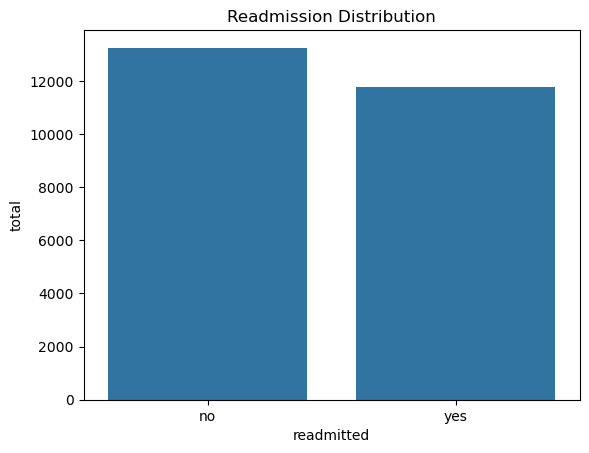

In [31]:
#Readmission Distribution
query = """
SELECT readmitted, COUNT(*) as total
FROM admissions
GROUP BY readmitted;
"""

df_readmit = pd.read_sql(query, engine)

sns.barplot(data=df_readmit, x="readmitted", y="total")
plt.title("Readmission Distribution")
plt.show()


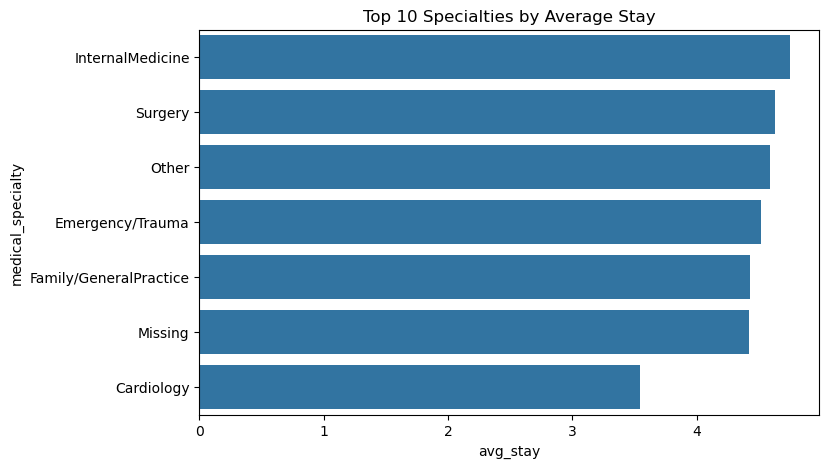

In [32]:
#Average Stay by Specialty
query = """
SELECT medical_specialty,
       AVG(time_in_hospital) AS avg_stay
FROM admissions
GROUP BY medical_specialty
ORDER BY avg_stay DESC
LIMIT 10;
"""

df_avg = pd.read_sql(query, engine)

plt.figure(figsize=(8,5))
sns.barplot(data=df_avg, y="medical_specialty", x="avg_stay")
plt.title("Top 10 Specialties by Average Stay")
plt.show()


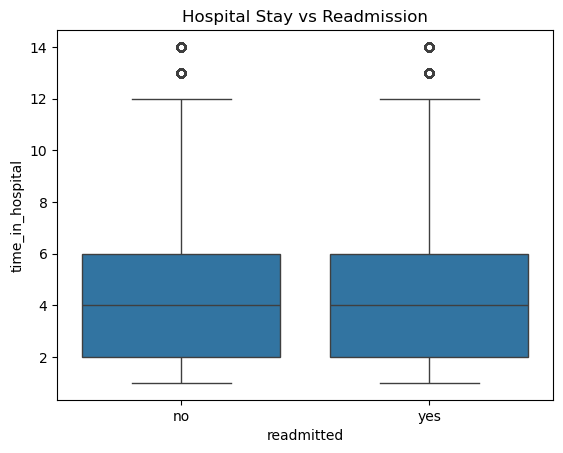

In [33]:
#Time in Hospital vs Readmission
query = """
SELECT time_in_hospital, readmitted
FROM admissions;
"""

df_time = pd.read_sql(query, engine)

sns.boxplot(data=df_time, x="readmitted", y="time_in_hospital")
plt.title("Hospital Stay vs Readmission")
plt.show()


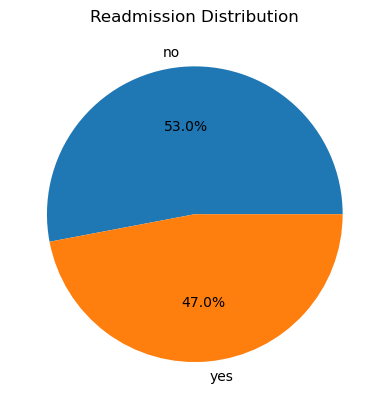

In [34]:
#Readmission Distribution (Pie Chart)
query = """
SELECT readmitted, COUNT(*) AS total
FROM admissions
GROUP BY readmitted;
"""
readmission_df = pd.read_sql(query, engine)
readmission_df

plt.figure()
plt.pie(readmission_df['total'], labels=readmission_df['readmitted'], autopct='%1.1f%%')
plt.title("Readmission Distribution")
plt.show()


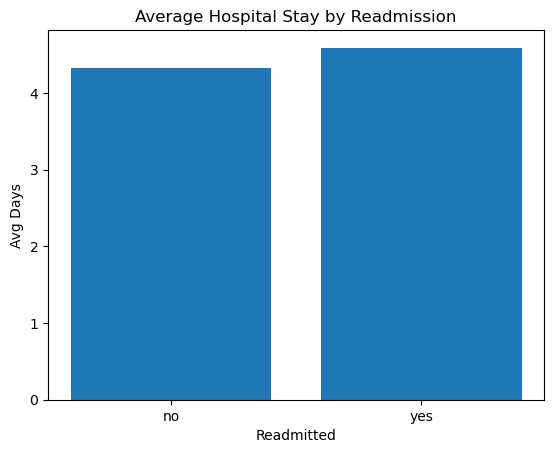

In [35]:
#Avg Hospital Stay by Readmission
query = """
SELECT readmitted, 
       ROUND(AVG(time_in_hospital),2) AS avg_stay
FROM admissions
GROUP BY readmitted;
"""
stay_df = pd.read_sql(query, engine)
stay_df
plt.figure()
plt.bar(stay_df['readmitted'], stay_df['avg_stay'])
plt.title("Average Hospital Stay by Readmission")
plt.xlabel("Readmitted")
plt.ylabel("Avg Days")
plt.show()


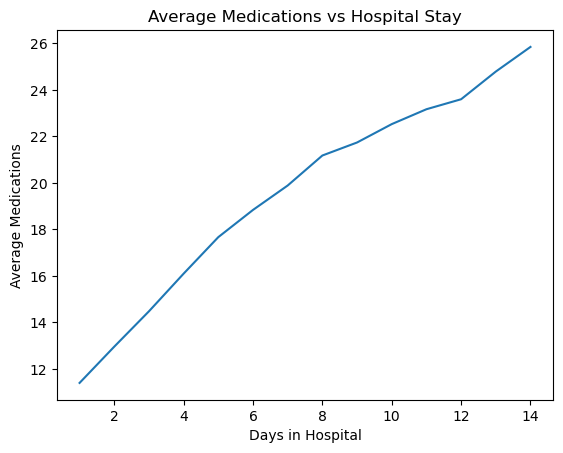

In [36]:
#Avg Medications by Hospital Stay (Line Chart)
query = """
SELECT time_in_hospital,
       ROUND(AVG(n_medications),2) AS avg_medications
FROM admissions
GROUP BY time_in_hospital
ORDER BY time_in_hospital;
"""
med_df = pd.read_sql(query, engine)
med_df
plt.figure()
plt.plot(med_df['time_in_hospital'], med_df['avg_medications'])
plt.title("Average Medications vs Hospital Stay")
plt.xlabel("Days in Hospital")
plt.ylabel("Average Medications")
plt.show()


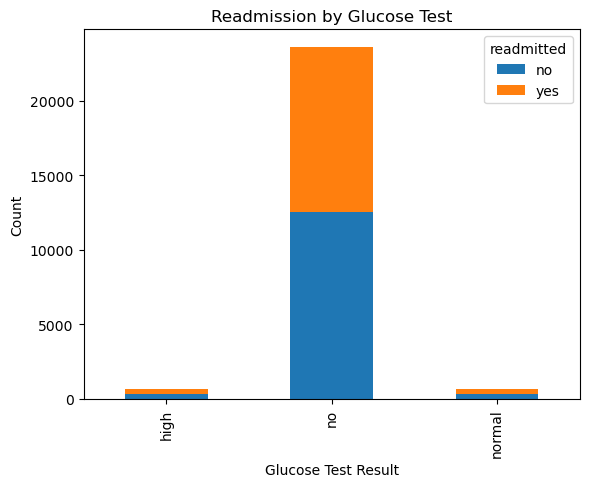

In [37]:
#Readmission by Glucose Test (Stacked Bar)
query = """
SELECT glucose_test, readmitted, COUNT(*) AS total
FROM admissions
GROUP BY glucose_test, readmitted
ORDER BY glucose_test;
"""
glucose_df = pd.read_sql(query, engine)
glucose_df
pivot_glucose = glucose_df.pivot(index='glucose_test',
                                  columns='readmitted',
                                  values='total')

pivot_glucose.plot(kind='bar', stacked=True)
plt.title("Readmission by Glucose Test")
plt.xlabel("Glucose Test Result")
plt.ylabel("Count")
plt.show()



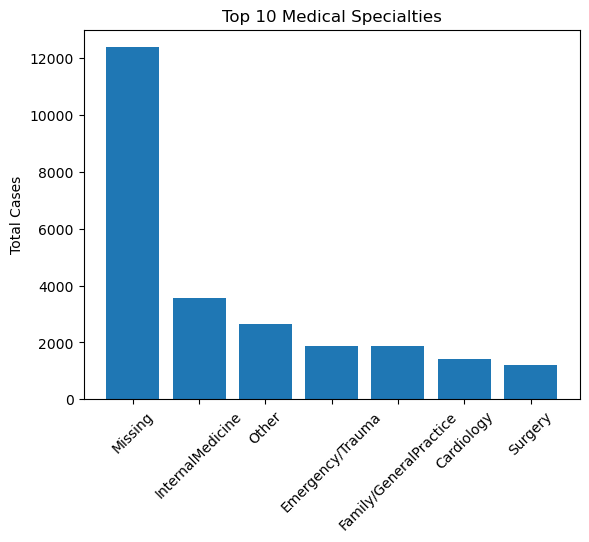

In [38]:
#Top Medical Specialties (Bar Chart)
query = """
SELECT medical_specialty,
       COUNT(*) AS total_cases
FROM admissions
GROUP BY medical_specialty
ORDER BY total_cases DESC
LIMIT 10;
"""
specialty_df = pd.read_sql(query, engine)
specialty_df
plt.figure()
plt.bar(specialty_df['medical_specialty'], specialty_df['total_cases'])
plt.xticks(rotation=45)
plt.title("Top 10 Medical Specialties")
plt.ylabel("Total Cases")
plt.show()


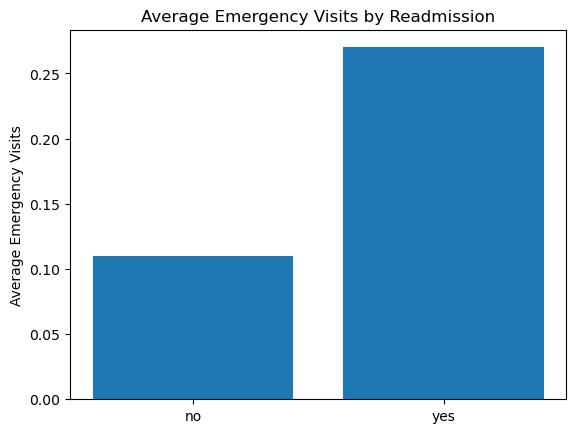

In [39]:
#Emergency Visits vs Readmission (Advanced SQL – CTE)
query = """
WITH emergency_stats AS (
    SELECT 
        readmitted,
        ROUND(AVG(n_emergency),2) AS avg_emergency
    FROM admissions
    GROUP BY readmitted
)
SELECT * FROM emergency_stats;
"""
emergency_df = pd.read_sql(query, engine)
emergency_df
plt.figure()
plt.bar(emergency_df['readmitted'], emergency_df['avg_emergency'])
plt.title("Average Emergency Visits by Readmission")
plt.ylabel("Average Emergency Visits")
plt.show()


In [72]:
!pip install docx
!pip install python-docx


In [74]:
# =============================
# HOSPITAL READMISSION REPORT GENERATOR
# =============================

import os
from docx import Document
from docx.shared import Inches
from datetime import datetime
import matplotlib.pyplot as plt

# 📁 Create Folder
folder_name = "Hospital_Report_Output"
os.makedirs(folder_name, exist_ok=True)

# Create document
document = Document()
document.add_heading("Hospital Admissions & Readmission Analysis Report", level=1)
document.add_paragraph(f"Generated on: {datetime.today().strftime('%Y-%m-%d')}")

# Function to add table
def add_table(df, title):
    document.add_heading(title, level=2)
    table = document.add_table(rows=df.shape[0] + 1, cols=df.shape[1])
    table.style = "Table Grid"
    
    for col_num, column_name in enumerate(df.columns):
        table.rows[0].cells[col_num].text = str(column_name)
    
    for row in range(df.shape[0]):
        for col in range(df.shape[1]):
            table.rows[row + 1].cells[col].text = str(df.iat[row, col])

# Function to add chart
def add_chart(fig, filename):
    filepath = os.path.join(folder_name, filename)
    fig.savefig(filepath, bbox_inches='tight')
    plt.close(fig)
    document.add_picture(filepath, width=Inches(5))


# 1. Readmission Distribution
add_table(df_readmit, "1. Readmission Distribution")

fig1 = plt.figure()
plt.bar(df_readmit['readmitted'], df_readmit['total'])
plt.title("Readmission Distribution")
plt.xlabel("Readmitted")
plt.ylabel("Total")
add_chart(fig1, "chart1.png")


# 2. Top 10 Specialties by Average Stay
add_table(df_avg, "2. Top 10 Specialties by Average Stay")

fig2 = plt.figure()
plt.barh(df_avg['medical_specialty'], df_avg['avg_stay'])
plt.title("Top 10 Specialties by Average Stay")
plt.xlabel("Average Stay")
add_chart(fig2, "chart2.png")


# 3. Average Stay by Readmission
add_table(stay_df, "3. Average Hospital Stay by Readmission")

fig3 = plt.figure()
plt.bar(stay_df['readmitted'], stay_df['avg_stay'])
plt.title("Average Stay by Readmission")
plt.xlabel("Readmitted")
plt.ylabel("Average Days")
add_chart(fig3, "chart3.png")


# 4. Average Medications vs Hospital Stay
add_table(med_df, "4. Average Medications vs Hospital Stay")

fig4 = plt.figure()
plt.plot(med_df['time_in_hospital'], med_df['avg_medications'])
plt.title("Average Medications vs Hospital Stay")
plt.xlabel("Days in Hospital")
plt.ylabel("Average Medications")
add_chart(fig4, "chart4.png")


# 5. Readmission by Glucose Test
add_table(glucose_df, "5. Readmission by Glucose Test")

pivot_glucose = glucose_df.pivot(
    index='glucose_test',
    columns='readmitted',
    values='total'
)

fig5, ax = plt.subplots(figsize=(6,4))
pivot_glucose.plot(kind='bar', stacked=True, ax=ax)
ax.set_title("Readmission by Glucose Test")
ax.set_xlabel("Glucose Test Result")
ax.set_ylabel("Count")
plt.tight_layout()
add_chart(fig5, "chart5.png")


# 6. Top 10 Medical Specialties
add_table(specialty_df, "6. Top 10 Medical Specialties")

fig6 = plt.figure()
plt.bar(specialty_df['medical_specialty'], specialty_df['total_cases'])
plt.xticks(rotation=45)
plt.title("Top 10 Medical Specialties")
plt.ylabel("Total Cases")
add_chart(fig6, "chart6.png")


# 📄 Save Word file inside folder
report_path = os.path.join(folder_name, "Complete_Hospital_Readmission_Report.docx")
document.save(report_path)

print("Report generated successfully!")
print("Saved inside folder:", folder_name)


Report generated successfully!
Saved inside folder: Hospital_Report_Output
